In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '1'

from pathlib import Path
from multiprocessing import Pool
from tqdm.auto import tqdm
import re

import numpy as np
from scipy import optimize
from matplotlib import pyplot as plt
import matplotlib.colors

import noctiluca as nl

In [2]:
def find_timestep(npy):
    tim = npy['tim']
    tid = npy['tid']

    dt = np.diff(tim)[np.diff(tid) == 0] # exclude steps across different trajectories
    if np.any(dt == 0):
        raise ValueError("Found zero time lag!")

    # Numerics might be better if everything is O(1)
    scale = np.min(dt)
    dt = dt / scale
    mindt = np.min(dt)
    
    # Step 1: rough estimate through MSE
    def mse(step):
        ints = np.round(dt/step).astype(int)
        return np.sum((dt-step*ints)**2)

    res = optimize.minimize(mse, mindt,
                            bounds=[(mindt, np.inf)],
                           )
    if not res.success:
        print(res)
        raise RuntimeError

    step = res.x

    # Step 2: identify real integer steps
    udts = []
    Ns = []
    cur = 0.5*step
    while cur < np.max(dt):
        ind = (dt > cur) & (dt < cur+step)
        Ns.append(np.sum(ind))
        if Ns[-1] > 0:
            udts.append(np.mean(dt[ind]))
            cur = udts[-1] + 0.5*step
        else:
            udts.append(np.nan)
            cur += step
    udts = np.array(udts)
    Ns   = np.array(Ns)

    # Step 3: fit actual best lag time
    ind = ~np.isnan(udts)
    with np.errstate(divide='ignore'):
        sigma = 1/np.sqrt(Ns[ind]-1)
    res = optimize.curve_fit(lambda x, a: a*x,
                             np.arange(len(udts))[ind]+1,
                             udts[ind],
                             sigma=sigma,
                            )

    return res[0][0]*scale

In [3]:
def load_file(file, relpath, dt_dict=None):
    npy = np.load(file)
    dt = find_timestep(npy)
    
    tim = npy['tim']
    tid = npy['tid']
    loc = npy['itr'][:, -1]['loc'][:, :2] # (#loc, 2) (we ignore z, since data is 2D)
    
    utid = np.unique(tid)
    
    data = nl.TaggedSet()
    for my_tid in utid:
        ind = tid == my_tid
        my_tim = tim[ind]
        my_loc = loc[ind]
        
        lag = np.round(np.diff(my_tim)/dt).astype(int)
        t = np.insert(np.cumsum(lag), 0, 0)
        
        traj = nl.Trajectory(my_loc, t=t, tid=my_tid, dt=dt)
        data.add(traj)
    
    relfile = file.relative_to(relpath)
    data.addTags(f'file={str(relfile)}')
    data.addTags(filename2tags(relfile))
    
    if dt_dict is not None:
        dt_dict[str(relfile)] = dt
    
    return data

In [4]:
def filename2tags(f):
    s = str(f)
    tags = set()
    
    system = re.search('array|H2B', s)[0]
    tags |= {'system='+system, system}

    L = re.search('L\d+', s)[0]
    tags |= {'L='+L[1:]}
    
    return tags

In [5]:
path = Path('../npy_exported_data/')
files = []
files += list((path).rglob('*.npy'))
len(files)

129

In [6]:
dt_dict = {}
data = nl.TaggedSet()
for f in tqdm(files):
    data |= load_file(f, path, dt_dict)

  0%|          | 0/129 [00:00<?, ?it/s]

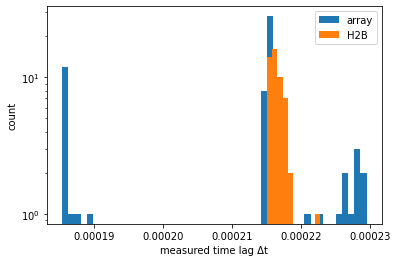

185.45400137735837 array/L150 noCFR/240823-122439_minflux.npy
185.5225479139219 array/L150 noCFR/240823-122105_minflux.npy
185.53228058194614 array/L150 noCFR/240823-122920_minflux.npy
185.64096659903038 array/L150 noCFR/240823-123143_minflux.npy
185.69679923052877 array/L150 noCFR/240823-122358_minflux.npy
185.72384599356326 array/L150 noCFR/240823-122840_minflux.npy
185.80920792866644 array/L150 noCFR/240823-123443_minflux.npy
185.82519903471402 array/L150 noCFR/240823-122510_minflux.npy
185.89480075952497 array/L150 noCFR/240823-123348_minflux.npy
185.98487058366024 array/L150 noCFR/240823-122539_minflux.npy
185.9875758256328 array/L150 noCFR/240823-122220_minflux.npy
186.27749397039943 array/L150 noCFR/240823-122656_minflux.npy
186.38001346900748 array/L150 noCFR/240823-121906_minflux.npy
187.51647408985914 array/L150 noCFR/240823-122028_minflux.npy
189.11846275239327 array/L150 noCFR/240823-121950_minflux.npy
214.5631913298919 array/L200/240823-115828_minflux.npy
214.6972127447001

In [7]:
# Check time steps
dts = np.array([dt_dict[f] for f in dt_dict])
fs  = np.array([f          for f in dt_dict])

plt.hist(dts[np.array(['array' in f
                       for f in dt_dict])],
         bins='auto',
         label='array',
        )
plt.hist(dts[np.array(['H2B'   in f
                       for f in dt_dict])],
         bins='auto',
         label='H2B',
        )

plt.legend()
plt.yscale('log')
plt.xlabel('measured time lag Δt')
plt.ylabel('count')
plt.show()

ind = np.argsort(dts)
for i in ind:
    print(dts[i]*1e6, str(fs[i]))

In [8]:
# Some cleanup
data.makeSelection(lambda traj, _: traj.F < 2)
print(f"Deleting {len(data)} trajectories with < 2 localizations")
data.deleteSelection()

# Cut off first localization (why? maybe bc that's the first one, where we have to search for the locus)
for traj in data:
    i_start = np.nonzero(np.cumsum(~np.isnan(traj.abs()[:][:, 0])) == 2)[0][0]
    traj.data = traj.data[:, i_start:, :]

Deleting 126 trajectories with < 2 localizations


In [9]:
tagsets = []
for system in ['array', 'H2B']:
    data.makeSelection(system)
    Ls = sorted({int(tag[2:]) for tag in data.tagset() if tag.startswith('L=')})
    for L in Ls:
        tagsets.append({f'system={system}',
                        f'L={L}',
                       })
            
print('#trajs     tags')
print(50*'-')
            
N_total = 0
for tags in tagsets:
    data.makeSelection(tags, logic=all)
    taglist = []
    for ident in ['system', 'L']:
        tgs = {tag for tag in tags if tag.startswith(ident+'=')}
        if len(tgs) > 0:
            taglist.append(tgs.pop())
            
    print(f'{len(data):5d}      '+(len(taglist)*'{:20s}').format(*taglist))
    N_total += len(data)

print(50*'-')
data.makeSelection(lambda _, tags: not any(all(tag in tags for tag in tagset)
                                           for tagset in tagsets))
print(f'{len(data):5d}      '+'<none of the above; just to check>')

print(50*'-')
data.makeSelection()
print(f'{N_total:5d}      '+'sum of above')
print(f'{len(data):5d}      '+'total in data set')

#trajs     tags
--------------------------------------------------
  186      system=array        L=100               
  907      system=array        L=150               
  563      system=array        L=200               
  648      system=H2B          L=100               
  571      system=H2B          L=150               
  569      system=H2B          L=175               
  580      system=H2B          L=200               
  920      system=H2B          L=250               
--------------------------------------------------
    0      <none of the above; just to check>
--------------------------------------------------
 4944      sum of above
 4944      total in data set


In [10]:
def tags2label(tags, omit=set()):
    taglist = []
    for ident in ['system', 'L']:
        if ident in omit:
            continue
            
        tgs = {tag for tag in tags if tag.startswith(ident+'=')}
        if len(tgs) > 0:
            tag = tgs.pop()
            
            val = re.match(ident+'=(.*)', tag)[1]
            if ident == 'L':
                val = 'L'+val
                
            taglist.append(val)
    
    return ', '.join(taglist)

In [11]:
conditions = []
for tags in tagsets:
    data.makeSelection(tags, logic=all)
    cond = tags2label(tags)
    data.addTags({cond, 'condition='+cond})
    conditions.append(cond)

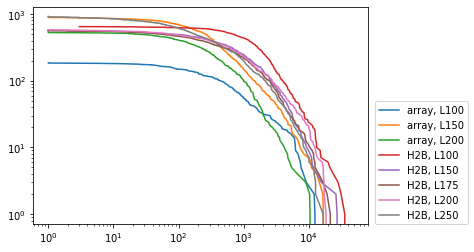

In [12]:
# Check survival curves
# --> *need* proper parallelization for MSD calculation, otherwise we're screwed hard
for cond in conditions:
    data.makeSelection(cond)
    
    lens = np.flip(np.sort(list(map(len, data))))
    Fs   = np.flip(np.sort(list(map(lambda traj : traj.F, data))))

    plt.plot(lens, np.arange(len(lens)), label=cond)
    # plt.plot(Fs, np.arange(len(Fs)))

plt.xscale('log')
plt.yscale('log')
plt.legend(loc=(1.02, 0.0))

plt.show()

In [13]:
# Pre-compute MSDs
def parfun(args):
    i, traj = args
    
    _ = nl.analysis.MSD(traj)
    
    return i, traj.meta['MSD']

data.makeSelection()
todo = list(enumerate(data))
with Pool() as mypool:
    imap = mypool.imap_unordered(parfun, todo)
    imap = tqdm(imap, total=len(todo))
    for i, meta in imap:
        data[i].meta['MSD'] = meta

  0%|          | 0/4944 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [20]:
data.makeSelection(lambda traj, _: 'MSD' not in traj.meta)
print(len(data))

for traj in data:
    print(len(traj))

0


In [19]:
# Can use this to do MSD by hand, if the above parallelization doesn't wanna do it
_ = nl.analysis.MSD(data[0])

In [21]:
data.makeSelection()
nl.io.write.hdf5({
    'data'       : data,
    'conditions' : conditions,
    'tagsets'    : tagsets,
    'dt_dict'    : dt_dict,
    'description' : """
L-sweep for second try of MINFLUX acquisition

array and H2B data, raw, with different L.

Contents of this file:
 - 'data'       : the data
 - 'conditions' : list of strings identifying each of the conditions;
                  can be used as tags in 'data'
 - 'tagsets'    : list of sets of tags into 'data', corresponding to
                  'conditions'; might be useful
 - 'dt_dict'    : lag time extracted from each file. Note that trajectories
                  in 'data' also have meta-entries 'dt'. Note that for proper
                  pooling, one might want to pool these time steps as well.
                  There seem to be three classes:
                   - (array, L150 no CFR) is around 186μs
                   - (array, L150) is around 227μs
                   - everything else seems consistent, at 216μs

Other notes:
 - The array data still contain background traces, which need to be removed
 - Likewise, we did not (yet) filter out short trajectories
 - the first localization of each trajectory has been removed
 - MSDs are pre-calculated for all trajectories
"""[1:-1],
}, '20240825_minflux2_L-sweep_raw.h5')